In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA,FastICA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    y_pred = model.predict(X_test)
    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [3]:
def plot_learning_curve(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

def plot_validation_curve(clf, X_train, y_train, param_name, cv):
    # Define the hyperparameter range
    param_range = np.arange(1, 21)

    # Calculate training and validation scores over the specified hyperparameter range
    train_scores, test_scores = validation_curve(
        clf, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1
    )

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title('Model Complexity Graph')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [5]:
models = []
file_path = "../notebooks/Obfuscated-MalMem2022.csv"
data = pd.read_csv(file_path)
# data.head()
# data.describe().T
# data.info()
data.drop(['handles.nport', 'pslist.nprocs64bit', 'svcscan.interactive_process_services'], axis=1, inplace=True)
data = data.sample(n=40000, random_state=42)


data['Class'].replace({'Benign':0, 'Malware':1}, inplace=True)
data[['Cat1', 'Cat2']] = data['Category'].str.extract('(\w+)-(\w+)-.*', expand=True).fillna('Benign')
label_encoder = LabelEncoder()
data['Cat1'] = label_encoder.fit_transform(data['Cat1'])
data['Cat2'] = label_encoder.fit_transform(data['Cat2'])

# correlation_matrix = data.corr()
# plt.figure(figsize=(40,40))
# sns.heatmap(correlation_matrix, annot=True, center=0)

data.drop(['Category'], axis=1, inplace=True)

X=data.drop('Class',axis=1)
y=data['Class']

<>:12: SyntaxWarning: invalid escape sequence '\w'
<>:12: SyntaxWarning: invalid escape sequence '\w'
C:\Users\abhis\AppData\Local\Temp\ipykernel_26096\1071359513.py:12: SyntaxWarning: invalid escape sequence '\w'
  data[['Cat1', 'Cat2']] = data['Category'].str.extract('(\w+)-(\w+)-.*', expand=True).fillna('Benign')
C:\Users\abhis\AppData\Local\Temp\ipykernel_26096\1071359513.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Class'].replace({'Benign':0, 'Malware':1}, inplace=True)
C:\Users\abhis\AppData\Local\Temp\ipy

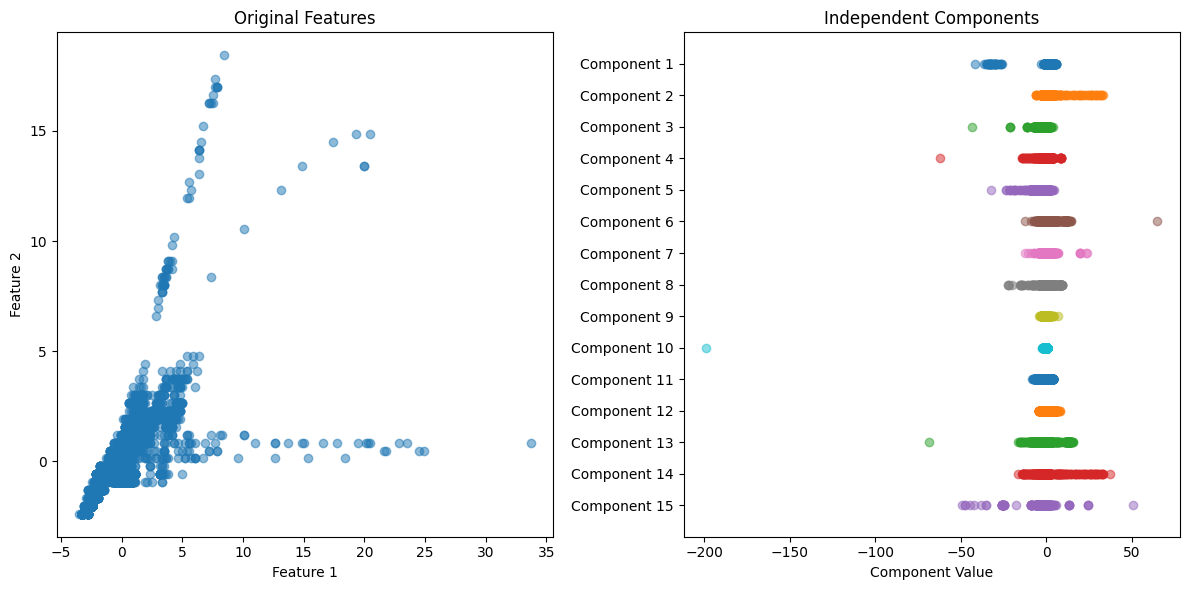

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Apply ICA
ica = FastICA(n_components=15, random_state=42)  # Specify the number of components
X_ica = ica.fit_transform(X)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot the original features
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5)
plt.title('Original Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot the independent components
plt.subplot(1, 2, 2)
for i in range(X_ica.shape[1]):
    plt.scatter(X_ica[:, i], np.zeros_like(X_ica[:, i]) + i, alpha=0.5)
plt.title('Independent Components')
plt.xlabel('Component Value')
plt.yticks(range(X_ica.shape[1]), [f'Component {i+1}' for i in range(X_ica.shape[1])])
plt.ylim(-1, X_ica.shape[1])
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

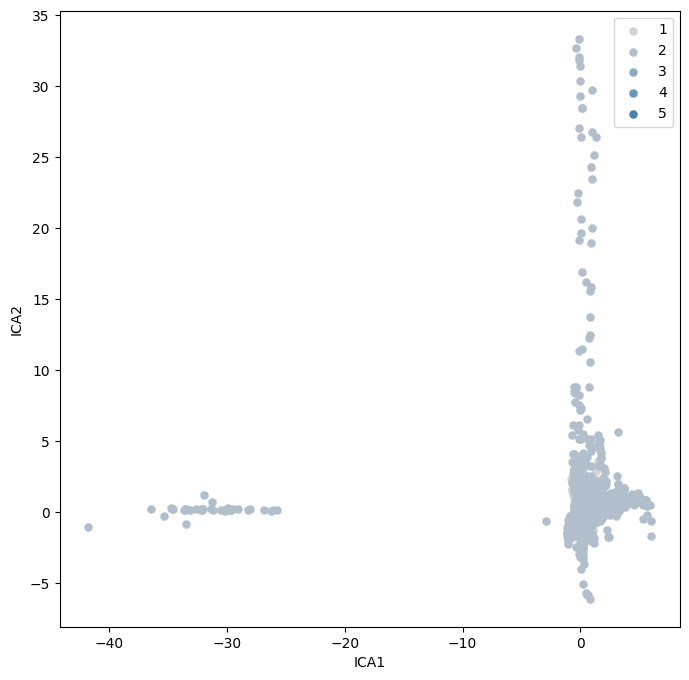

In [12]:
colors = ['#D3D3D3', '#B0BFCB', '#8DABC4', '#6996BC', '#4682B4']
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, [0,1,2,3,4], [1,2,3,4,5]):
    plt.scatter(X_ica[y == i, 0], X_ica[y == i, 1], color=color, lw=0.1, label=target_name)

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("ICA1")
plt.ylabel("ICA2")
plt.show()

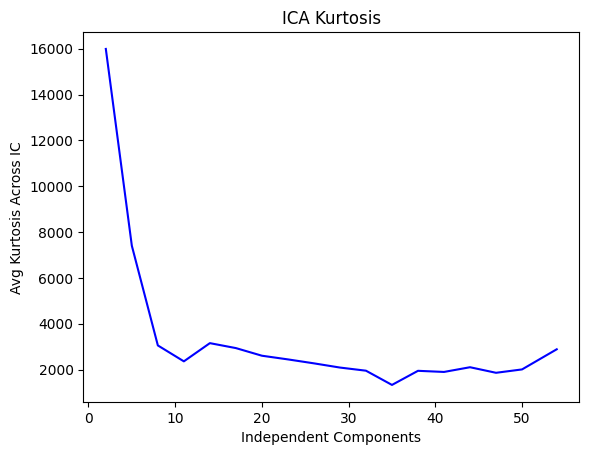

In [13]:
dims = list(np.arange(2,(X.shape[1]-1),3))
dims.append(X.shape[1])
ica = FastICA(random_state=5)
kurt = []

for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt.append(tmp.abs().mean())

plt.figure()
plt.title("ICA Kurtosis")
plt.xlabel("Independent Components")
plt.ylabel("Avg Kurtosis Across IC")
plt.plot(dims, kurt, 'b-')
plt.grid(False)
plt.show()